In [12]:
import torch
import random
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [20]:
class Consts:
    random.seed(42)
    block_size = 3  # Kontextová délka: kolik znaků použijeme k předpovědi dalšího?
    num_layers = 2  # Počet vrstev v modelu
    num_epochs = 10  # Počet epoch pro trén|ink
    file_path = 'names.txt'
    emb_dim = 2
    layer1_size = 100
    char_count = 27 # 26 znaků + tečka

class Vocabulary:
    def __init__(self):
        self.stoi, self.itos, self.words = Vocabulary.build_vocab(Consts.file_path)
        
    def build_vocab(file_path):
        with open(file_path, 'r') as file: # Načtení slov ze souboru
            words = file.read().splitlines()
        chars = sorted(list(set(''.join(words))))
        stoi = {s: i+1 for i, s in enumerate(chars)}
        stoi['.'] = 0
        itos = {i: s for s, i in stoi.items()}
        return stoi, itos, words

vocab = Vocabulary()

class Dataset:
    def __init__(self):
        random.shuffle(vocab.words)
        n1 = int(0.8*len(vocab.words))
        n2 = int(0.9*len(vocab.words))
        self.Xtr, self.Ytr = Dataset.build_dataset(vocab.words[:n1])
        self.Xdev, self.Ydev = Dataset.build_dataset(vocab.words[n1:n2])
        self.Xte, self.Yte = Dataset.build_dataset(vocab.words[n2:])

    def build_dataset(words):  
      X, Y = [], []
      for w in words:
        context = [0] * Consts.block_size
        for ch in w + '.':
          ix = vocab.stoi[ch]
          X.append(context)
          Y.append(ix)
          #print(''.join(itos[i] for i in context), '--->', itos[ix])
          context = context[1:] + [ix] # crop and append
      X = torch.tensor(X)
      Y = torch.tensor(Y)
      return X, Y

data = Dataset()
X, Y = data.Xtr, data.Ytr

In [25]:


emb = C[X] # embedded chars obtained by indexing the lookup table
h = torch.tanh(emb.view(-1, Consts.block_size * Consts.emb_dim) @ W1 + b1) # vystup prvni vrstvy
logits = h @ W2 + b2 # vystup posledni vrstvy
counts = logits.exp()
prob = counts / counts.sum(1, keepdims=True)
loss = -prob[torch.arange(228146), Y].log().mean()

In [20]:
class Model:
    def __init__(self):
        g = torch.Generator().manual_seed(2147483647) # for reproducibility
        self.C = torch.randn((Consts.char_count, Consts.emb_dim), generator=g)
        self.W1 = torch.randn((Consts.block_size * Consts.emb_dim, Consts.layer1_size), generator=g)
        self.b1 = torch.randn(Consts.layer1_size, generator=g)
        self.W2 = torch.randn((Consts.layer1_size, Consts.char_count), generator=g)
        self.b2 = torch.randn(Consts.char_count, generator=g)
        self.parameters = [self.C, self.W1, self.b1, self.W2, self.b2]

    def forward(self, X):
        emb = self.C[X] # embedded chars obtained by indexing the lookup table
        h = torch.tanh(emb.view(-1, Consts.block_size * Consts.emb_dim) @ self.W1 + self.b1) # vystup prvni vrstvy
        logits = h @ self.W2 + self.b2 # vystup posledni vrstvy
        return logits

    def loss(self, logits, Y):
        counts = logits.exp()
        prob = counts / counts.sum(1, keepdims=True)
        loss = -prob[torch.arange(228146), Y].log().mean()
        return loss

    def train(self, X, Y, epochs=10, lr=0.1):
        for p in self.parameters:
            p.requires_grad = True
        for i in range(epochs):
            emb = self.C[X] # (32, 3, 2)
            h = torch.tanh(emb.view(-1, 30) @ self.W1 + self.b1) # (32, 100)
            logits = h @ self.W2 + self.b2 # (32, Consts.char_count)
            loss = self.loss(logits, Y)
            print(loss.item())
            for p in self.parameters:
                p.grad = None
            loss.backward()
            for p in self.parameters:
                p.data += -lr * p.grad

In [30]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [31]:
lri = []
lossi = []
stepi = []

In [32]:
for i in range(200000):
  
  # minibatch construct
  ix = torch.randint(0, X.shape[0], (32,))
  
  # forward pass
  emb = C[X[ix]] # (32, 3, 10)
  h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 200)
  logits = h @ W2 + b2 # (32, Consts.char_count)
  loss = F.cross_entropy(logits, Y[ix])
  #print(loss.item())
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  #lr = lrs[i]
  lr = 0.1 if i < 100000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  #lri.append(lre[i])
  stepi.append(i)
  lossi.append(loss.log10().item())

#print(loss.item())

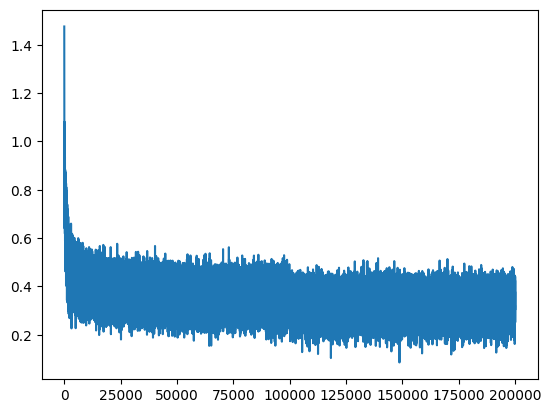

In [33]:
plt.plot(stepi, lossi)

In [34]:
emb = C[X] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, Consts.char_count)
loss = F.cross_entropy(logits, Y)
loss

tensor(2.1201, grad_fn=<NllLossBackward0>)

In [35]:
emb = C[data.Xdev] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, Consts.char_count)
loss = F.cross_entropy(logits, data.Ydev)
loss

tensor(2.1610, grad_fn=<NllLossBackward0>)

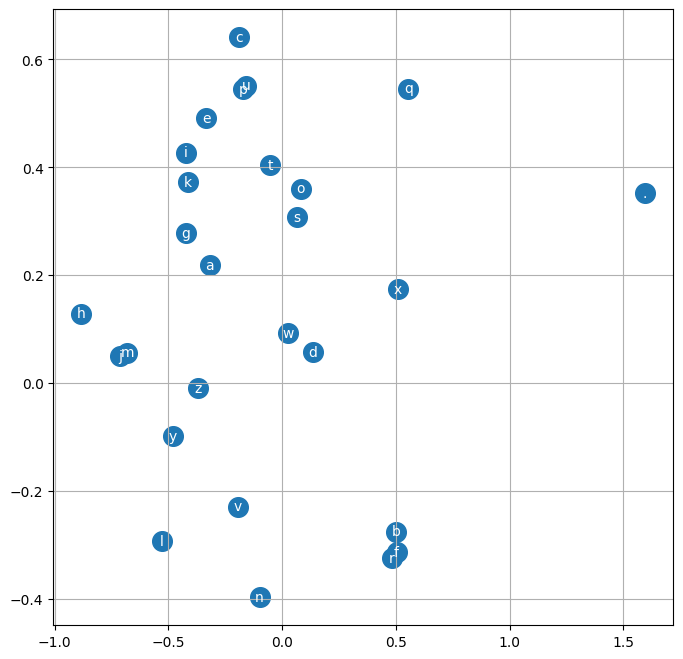

In [36]:
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), vocab.itos[i], ha="center", va="center", color='white')
plt.grid('minor')

In [37]:
# training split, dev/validation split, test split
# 80%, 10%, 10%

In [38]:
context = [0] * Consts.block_size
C[torch.tensor([context])].shape

torch.Size([1, 3, 10])

In [50]:


# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)
def sample_from_model(word_count):
  for _ in range(word_count):
      
      out = []
      context = [0] * Consts.block_size # initialize with all ...
      while True:
        emb = C[torch.tensor([context])] # (1,block_size,d)
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
          break
      
      print(''.join(vocab.itos[i] for i in out))
      
word_count = 20
sample_from_model(word_count)

carpaveato.
hari.
kemriggtef.
khalaysa.
jazonevalee.
rha.
kaeli.
neronia.
chaiiv.
kaleigh.
ham.
pris.
quint.
suline.
liveni.
wazell.
dearyx.
karmeeniveli.
emaediia.
gian.


In [39]:
# sum(p.nelement() for p in parameters) # number of parameters in total